In [1]:
from classy import Class
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import scipy.integrate as sc
#plt.rcParams.update({   "text.usetex": True,})


In [2]:
# all output er i newtonian gauge af historiske årsager du kan overveje at udkommetnere gaugetransformation i koden senere.

In [3]:
kvec = np.logspace(1e-3,1e1,20)#
kvec = [1e-3,1e-2,1e-1,1,1e1]
print(kvec)
Omega_M = 0.3
Omega_R = 7e-5
Omega_lambda = 1 - Omega_M - Omega_R
H0 = 67 / (3*1e5) # i 1/Mpc
cosmo_dict ={'H0':70, 'Omega_b':0.05, 'Omega_cdm':0.25, 'k_output_values':str(kvec).strip('[]'), 
           'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',}

cosmo = Class()
cosmo.set(cosmo_dict)
cosmo.compute()
bg = cosmo.get_background()

pts = cosmo.get_perturbations()['scalar']
print(bg.keys())
pts0=pts[0]
print(f"{pts0.keys()=}")
print( cosmo.Hubble(0))


[0.001, 0.01, 0.1, 1, 10.0]
dict_keys(['z', 'proper time [Gyr]', 'conf. time [Mpc]', 'H [1/Mpc]', 'comov. dist.', 'ang.diam.dist.', 'lum. dist.', 'comov.snd.hrz.', '(.)rho_g', '(.)rho_b', '(.)rho_cdm', '(.)rho_lambda', '(.)rho_ur', '(.)rho_crit', '(.)rho_tot', '(.)p_tot', '(.)p_tot_prime', 'gr.fac. D', 'gr.fac. f'])
pts0.keys()=dict_keys(['tau [Mpc]', 'a', 'delta_g', 'theta_g', 'shear_g', 'pol0_g', 'pol1_g', 'pol2_g', 'delta_b', 'theta_b', 'psi', 'phi', 'delta_ur', 'theta_ur', 'shear_ur', 'delta_cdm', 'theta_cdm'])
0.00023349486663870643


# Forklaring

I den første del er det D(a) der simuleres. I den anden del simulerer jeg delta og theta explicit.



$\ddot{D} + \mathcal{H}\dot{D} - \frac{3}{2}\frac{{H_0}^2\Omega_m}{a}D=0$

Det medfører at, hvis vi sætter $\ddot{D}=0$, sp før vi et $D(\tau)$-afhængigt udtryk for $\dot{D}$

$\ddot{D} + \mathcal{H}\dot{D} - \frac{3}{2}\frac{{H_0}^2\Omega_m}{a}D=0$

$0 + \mathcal{H}\dot{D} - \frac{3}{2}\frac{{H_0}^2\Omega_m}{a}D=0$

$ \mathcal{H}\dot{D} = \frac{3}{2}\frac{{H_0}^2\Omega_m}{a}D$

$ \dot{D} = \frac{3}{2}\frac{{H_0}^2\Omega_m}{a\mathcal{H}}D$

In [4]:
z = bg["z"]
a = 1/(z+1)

Text(0.5, 0, 'a')

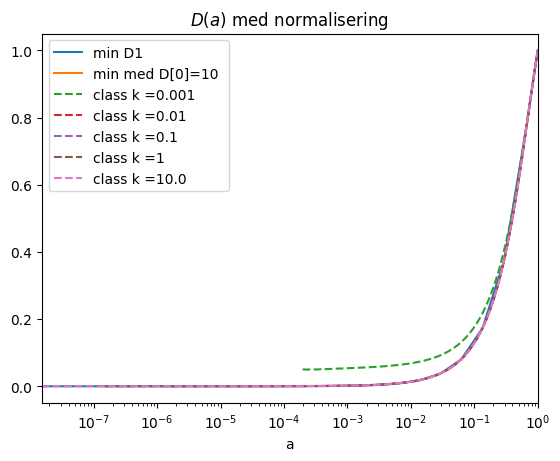

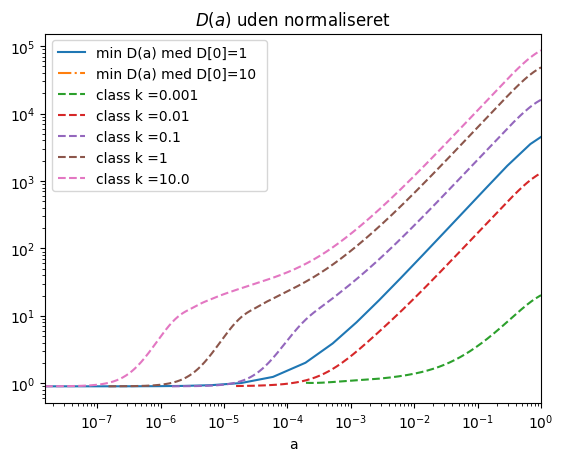

In [5]:
###########################################
### her regner jeg min version af delta ###

aend = a[-1]
pts0=pts[0]
a_class = pts[-1]['a']
a0 = a[0]#pts0['a'][0]
a0 = a_class[0]
def H(a):
    return H0 * np.sqrt(Omega_lambda + Omega_M /( a **3) + Omega_R /( a**4)) 

def tau_cal(a,y):
    # Vores "tids"-værdi i denne differentialligning er a
    tau = y[0]
    d_tau = 1 / (a ** 2 * H(a))
    return np.array(d_tau)

tau0 = (1/H0) * (Omega_R ** (-0.5)) * a0
sol_tau = sc.solve_ivp(tau_cal,t_span=[a0,aend],y0=[tau0])
tau =sol_tau.y[0]

def D_solve(tau,y):
    a = y[0]
    D = y[1]
    D_dt = y[2]
    a_dt = a * a * H(a)
    D2_dt2 = +  ((3 / 2) * H0 * H0 * Omega_M * D / a) - a * H(a) * D_dt 
    
    return [a_dt,D_dt,D2_dt2]

num = pts0["delta_cdm"][-1]

D0 = pts[-1]["delta_cdm"][0]
dDdt = 3/2 * H0**2 * Omega_M * D0 / (a0 * H(a0))
params = np.array([a0,D0,dDdt])
sol_D = sc.solve_ivp(D_solve,t_span = [tau0,tau[-1]], y0 = params)
a_sol_D = sol_D.y[0]


D0 = pts[-1]["delta_cdm"][0]
dDdt = 3/2 * H0**2 * Omega_M * D0 / (a0 * H(a0))
params = np.array([a0,D0,dDdt])
sol_D2 = sc.solve_ivp(D_solve,t_span = [tau0,tau[-1]], y0 = params)
D10 = sol_D2.y[1]
D10t = sol_D2.y[2]


#######################################
#########   figurene plottes ##########

plt.figure(1)
plt.semilogx(sol_D.y[0],sol_D.y[1]/sol_D.y[1][-1],label="min D1")
#plt.loglog(sol_D2.y[0],sol_D2.y[1]/sol_D2.y[1][-1],label="min D2")

plt.semilogx(D10t,D10/D10[-1],label="min med D[0]=10 ")
for i,k in enumerate(kvec):
    plt.semilogx(pts[i]["a"],pts[i]["delta_cdm"]/pts[i]["delta_cdm"][-1],"--",label="class k ="+str(kvec[i]))
plt.xlabel("a")
plt.legend()
plt.xlim([a_sol_D[0],a_sol_D[-1]])
plt.title(r"$D(a)$ med normalisering")
plt.xscale("log")

plt.figure(2)
plt.xlim([a_sol_D[0],a_sol_D[-1]])
plt.plot(sol_D.y[0],-sol_D.y[1],label=r"min D(a) med D[0]=1")
plt.plot(D10t,D10,"-.",label="min D(a) med D[0]=10 ")
plt.xscale("log")
plt.yscale("log")
for i,k in enumerate(kvec):
    plt.plot(pts[i]["a"],-pts[i]["delta_cdm"],"--",label="class k ="+str(kvec[i]))
plt.legend(loc="upper left")

plt.title(r"$D(a)$ uden normaliseret")
plt.xlabel("a")


Til i morgen. Find udaf det der med at din simulering lægger sig op af forskellige class k-værdier afhænigt af hvor mange kvec du giver class i starten.

Text(0.5, 0, 'a')

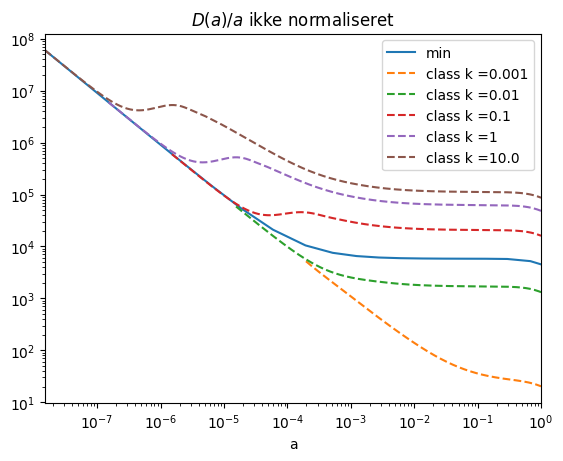

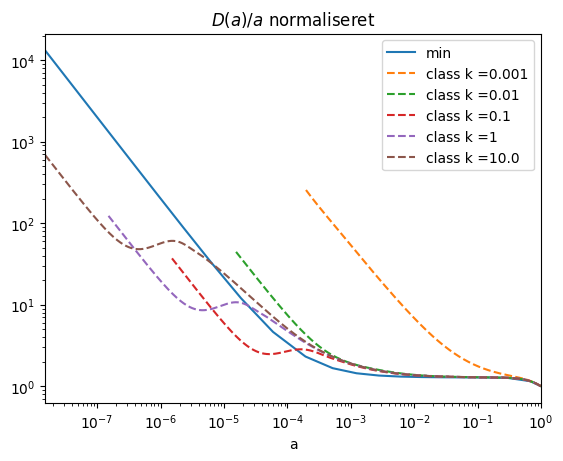

In [6]:
plt.figure(2)
a = a_sol_D
plt.xlim([a_sol_D[0],a_sol_D[-1]])
plt.loglog(sol_D.y[0],-sol_D.y[1]/a,label=r"min")
for i,k in enumerate(kvec):
    #continue
    plt.loglog(pts[i]["a"],-pts[i]["delta_cdm"]/pts[i]["a"],"--",label="class k ="+str(kvec[i]))
plt.legend()#loc="upper left")

plt.title(r"$D(a)/a$ ikke normaliseret")
plt.xlabel("a")

plt.figure(12313212)

plt.xlim([a_sol_D[0],a_sol_D[-1]])
#plt.ylim([0,1])
plt.loglog(sol_D.y[0],sol_D.y[1]/(a*sol_D.y[1][-1]),label=r"min")
for i,k in enumerate(kvec):
    #pass
    plt.loglog(pts[i]["a"],pts[i]["delta_cdm"]/(pts[i]["a"]*pts[i]["delta_cdm"][-1]),"--",label="class k ="+str(kvec[i]))
plt.legend()#loc="upper left")

plt.title(r"$D(a)/a$ normaliseret")
plt.xlabel("a")


Koden der står nedenunder var et forsøg på at plotte theta ud fra D, udne at have regnet delta(a) først.

NU simulerer jeg så delta og theta explicit.

$\dot{\delta} = -\theta$

Vi antager at $\theta = 0$

$\dot{\theta} = - \mathcal{H}\theta - \frac{3}{2}\frac{H_0 ^2 \Omega_M}{a}\delta$

$\dot{\theta} = - \mathcal{H}0 - \frac{3}{2}\frac{H_0 ^2 \Omega_M}{a}\delta$

$\dot{\theta} =  -\frac{3}{2}\frac{H_0 ^2 \Omega_M}{a}\delta$


0.00022333333333333333


Text(0.5, 0, 'a')

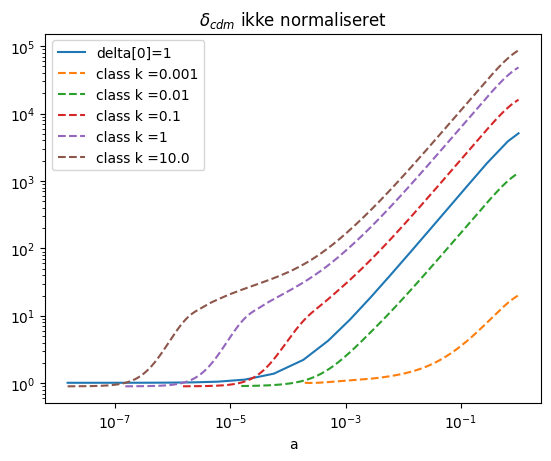

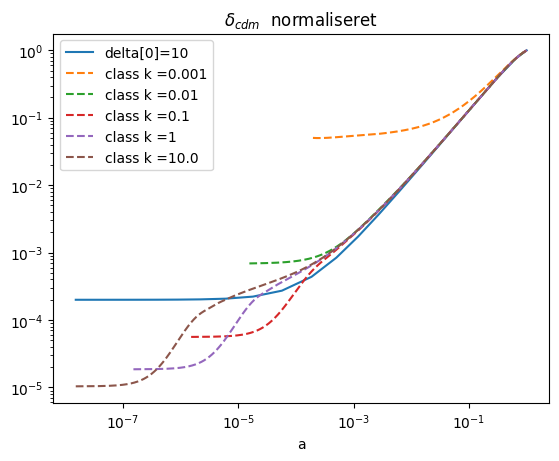

In [17]:
#
print(H0)
def D_solve(tau,y):
    a = y[0]
    delta = y[1]
    theta = y[2]
    a_dt = a * a * H(a)
    d_delta = - theta
    nabla2phi = (3/2) * H0*H0 * Omega_M * delta / a
    d_theta = - a* H(a) * theta - nabla2phi
    return np.array([a_dt,d_delta,d_theta])
    
    
tspan = np.array([tau0,tau[-1]])
a0 = tau0 * H0 * Omega_R ** 0.5

delta = pts[0]["delta_cdm"][0]
theta =  pts[0]["theta_cdm"][0]
y0 = [a0,delta,theta]
sol1 = sc.solve_ivp(D_solve,tspan,y0)
delta1 = np.abs(sol1.y[1])
plt.loglog(sol1.y[0],np.abs(sol1.y[1]),label="delta[0]=1")

delta = 10
theta = 0
y0 = [a0,delta,theta]
sol2 = sc.solve_ivp(D_solve,tspan,y0)
delta2 = np.abs(sol2.y[1])
#plt.loglog(sol2.y[0],np.abs(sol2.y[1]),label="delta[0]=10")
plt.title(r"$\delta_{cdm}$ ikke normaliseret")
plt.xlabel("a")
for i,k in enumerate(kvec):
    plt.plot(pts[i]["a"],-pts[i]["delta_cdm"],"--",label="class k ="+str(kvec[i]))
plt.legend()


plt.figure(2)
plt.loglog(sol1.y[0],np.abs(sol1.y[1])/np.abs(sol1.y[1])[-1],label="delta[0]=10")
#plt.loglog(sol2.y[0],np.abs(sol2.y[1])/np.abs(sol2.y[1])[-1],label="delta[0]=1")

plt.title(r"$\delta_{cdm}$  normaliseret")
for i,k in enumerate(kvec):
    plt.plot(pts[i]["a"],pts[i]["delta_cdm"]/pts[i]["delta_cdm"][-1],"--",label="class k ="+str(kvec[i]))
plt.legend()
plt.xlabel("a")

# $\theta$ 
Her plotter jeg theta som angivet i ligning 2.9 i dne der artikel hvor jeg udledt alle ligningerne.

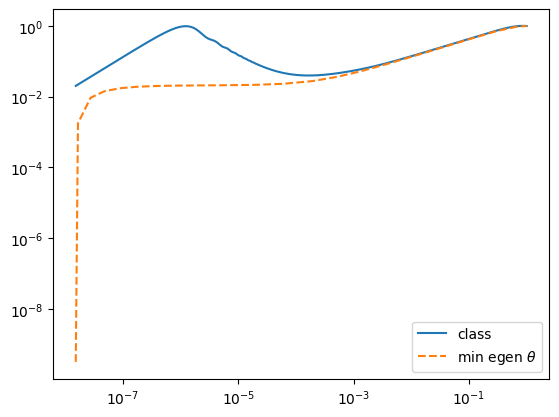

In [8]:

theta = pts[-1]["theta_cdm"]
plt.loglog(pts[-1]["a"],theta/theta[-1],label="class") 
min_theta = sol_D.y[2]/sol_D.y[1]
min_theta = sol_D.y[2]/sol_D.y[1]*sol1.y[1]
plt.loglog(a_sol_D, min_theta/min_theta[-1],"--",label=r"min egen $\theta$")
plt.legend()

Text(0.5, 0, 'a')

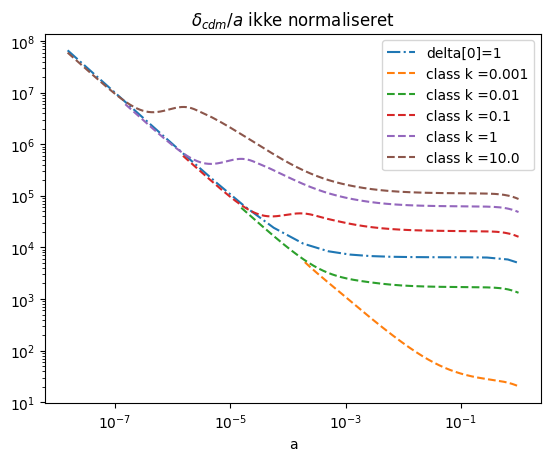

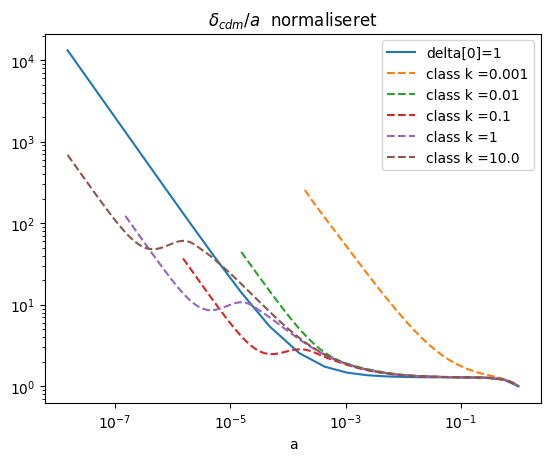

In [9]:

a2 = sol2.y[0]
a1 = sol1.y[0]
plt.loglog(a1,np.abs(sol1.y[1])/a1,"-.",label="delta[0]=1") 

#lt.loglog(a2,np.abs(sol2.y[1])/a2,label="delta[0]=10") 
plt.title(r"$\delta_{cdm}/a$ ikke normaliseret")
plt.xlabel("a")
for i,k in enumerate(kvec):
    plt.plot(pts[i]["a"],-pts[i]["delta_cdm"]/pts[i]["a"],"--",label="class k ="+str(kvec[i]))
plt.legend()

plt.figure(2)
plt.loglog(a2,np.abs(sol2.y[1])/np.abs(sol2.y[1])[-1]/a2,label="delta[0]=1")
#plt.loglog(a1,np.abs(sol1.y[1])/np.abs(sol1.y[1])[-1]/a1,"-.",label="delta[0]=10")

plt.title(r"$\delta_{cdm}/a$  normaliseret")
for i,k in enumerate(kvec):
    plt.plot(pts[i]["a"],pts[i]["delta_cdm"]/pts[i]["delta_cdm"][-1]/pts[i]["a"],"--",label="class k ="+str(kvec[i]))
plt.legend()
plt.xlabel("a")

Text(0.5, 0, 'a')

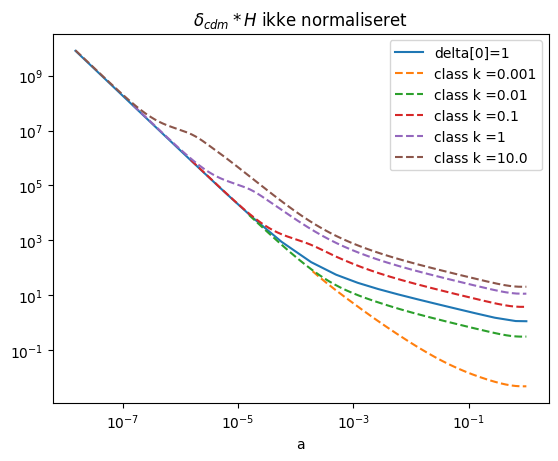

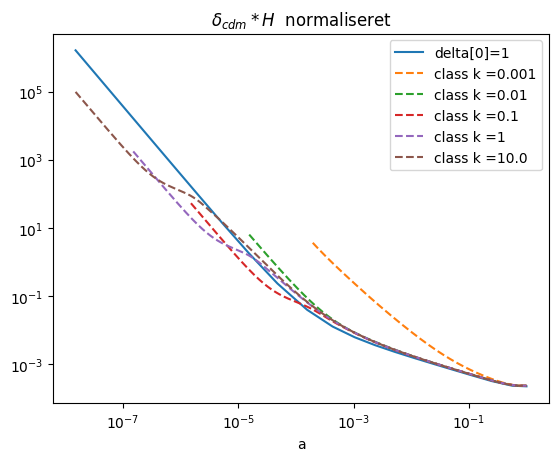

In [10]:
a2 = sol2.y[0]
a1 = sol1.y[0]
plt.loglog(a1,np.abs(sol1.y[1])*H(a1),label="delta[0]=1") 
#plt.loglog(a2,np.abs(sol2.y[1])*H(a2),label="delta[0]=10")
plt.title(r"$\delta_{cdm}*H$ ikke normaliseret")
plt.xlabel("a")
z =  1/pts[0]["a"] - 1
Hz = np.zeros(len(z))
Mega_Hz = []
for k_index,k in enumerate(kvec):
    Mega_Hz.append(np.zeros(len(pts[k_index]["delta_cdm"])))
    z = 1/pts[k_index]["a"] - 1
    for i,z_value in  enumerate(z):
        Mega_Hz[k_index][i] = cosmo.Hubble(z_value)

Hz = Mega_Hz
for i,k in enumerate(kvec):
    plt.plot(pts[i]["a"],-np.array(pts[i]["delta_cdm"])* Hz[i],"--",label="class k ="+str(kvec[i]))
plt.legend()

plt.figure(2)

plt.loglog(a2,np.abs(sol2.y[1])/np.abs(sol2.y[1])[-1]*H(a2),label="delta[0]=1") 
#plt.loglog(a1,np.abs(sol1.y[1])/np.abs(sol1.y[1])[-1]*H(a1),"-.",label="delta[0]=10")

plt.title(r"$\delta_{cdm}*H$  normaliseret")
for i,k in enumerate(kvec):
    
    plt.plot(pts[i]["a"],pts[i]["delta_cdm"]/pts[i]["delta_cdm"][-1]* Hz[i],"--",label="class k ="+str(kvec[i]))
plt.legend()
plt.xlabel("a")



# Semilog test

Text(0.5, 0, 'a')

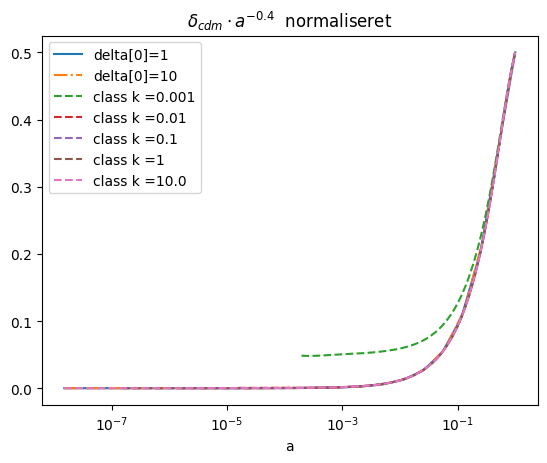

In [11]:
n = 0.4
m = 0
plt.figure(3)
#plt.
plt.semilogx(a2,np.abs(sol2.y[1])/np.abs(sol2.y[1])[-1]/(a2**n+a2**m),label="delta[0]=1") #/np.abs(sol.y[1][-1]))
plt.semilogx(a1,np.abs(sol1.y[1])/np.abs(sol1.y[1])[-1]/(a1**n+a1**m),"-.",label="delta[0]=10") #/np.abs(sol.y[1][-1]))

plt.title(r"$\delta_{cdm}\cdot a ^{-%s}$  normaliseret" % (n))
for i,k in enumerate(kvec):
    #pass
    a_k = pts[i]["a"]
    plt.semilogx(a_k,pts[i]["delta_cdm"]/pts[i]["delta_cdm"][-1]/(a_k**n+ a_k**m),"--",label="class k ="+str(kvec[i]))
plt.legend()
plt.xlabel("a")

[-31959.43081554  54211.27838921 -24581.13102063   2243.59146438]


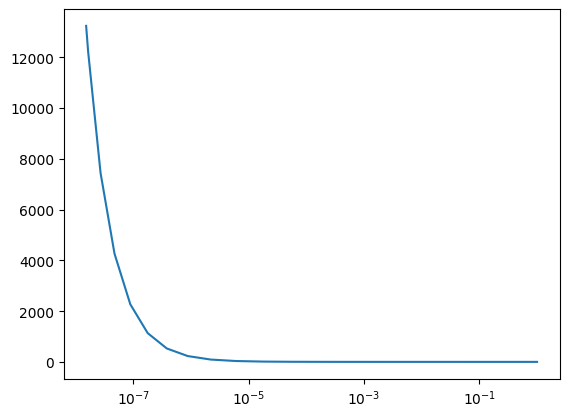

In [12]:
x = a1  
y = np.abs(sol1.y[1])/np.abs(sol1.y[1])[-1]/a1# (a1**n+a1**m)
plt.semilogx(x,y)
z = np.polyfit(x, y, 3)
print(z)

#p(0.5)

Text(0.5, 0, 'a')

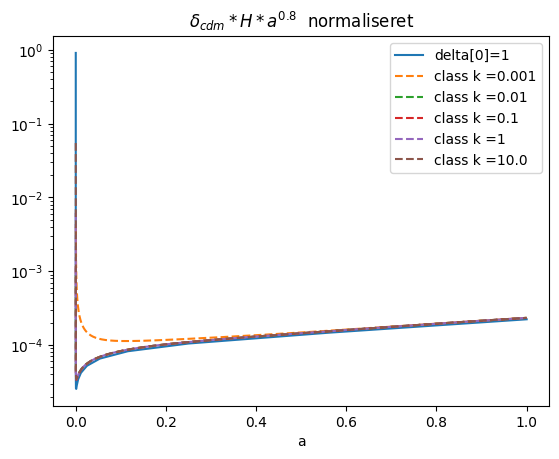

In [13]:
n = 1-2e-1
a2 = sol2.y[0]
a1 = sol1.y[0]


plt.semilogy(a2,np.abs(sol2.y[1])/np.abs(sol2.y[1])[-1]*H(a2)*a2**n,label="delta[0]=1") #/np.abs(sol.y[1][-1]))
#plt.semilogx(a1,np.abs(sol1.y[1])/np.abs(sol1.y[1])[-1]*H(a1)*a1**n,"-.",label="delta[0]=10") #/np.abs(sol.y[1][-1]))

plt.title(r"$\delta_{cdm}*H*a^{%s}$  normaliseret" % n )
for i,k in enumerate(kvec):
    #pass
    a_u = pts[i]["a"]
    plt.semilogy(a_u,pts[i]["delta_cdm"]/pts[i]["delta_cdm"][-1]* Hz[i]*a_u**n,"--",label="class k ="+str(kvec[i]))
plt.legend()
plt.xlabel("a")



Text(0.5, 0, 'a')

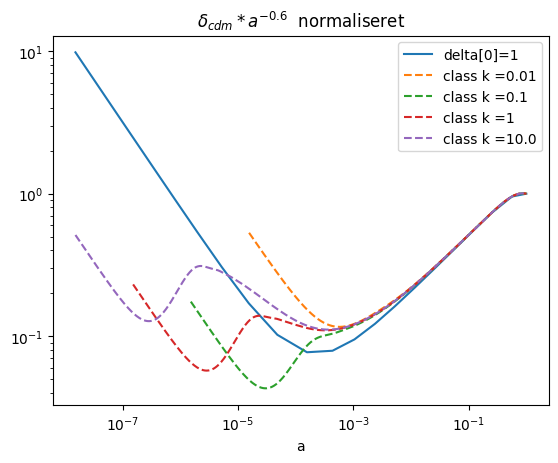

In [14]:
n = -0.6

plt.figure(2)
num = np.abs(sol2.y[1])[-1]
plt.loglog(a2,np.abs(sol2.y[1])/num*a2**n,label="delta[0]=1") #/np.abs(sol.y[1][-1]))
#plt.loglog(a1,np.abs(sol1.y[1])/num*a1**n,"-.",label="delta[0]=10") #/np.abs(sol.y[1][-1]))

plt.title(r"$\delta_{cdm}*a^{%s}$  normaliseret" % n )
for i,k in enumerate(kvec):
    #pass
    if k == 0.001:
        continue
    a_u = pts[i]["a"]
    plt.plot(a_u,pts[i]["delta_cdm"]/pts[i]["delta_cdm"][-1]*a_u**n,"--",label="class k ="+str(kvec[i]))
plt.legend()
plt.xlabel("a")



Text(0.5, 0, 'a')

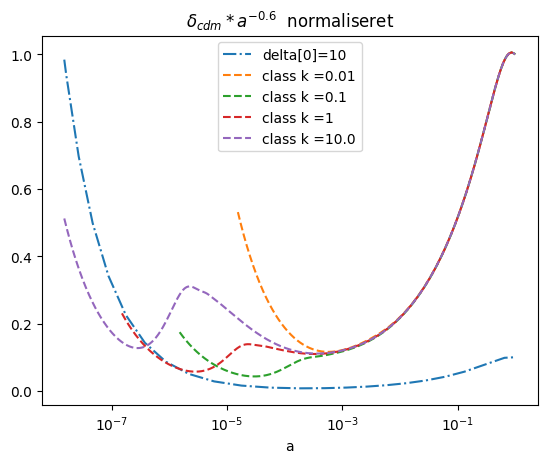

In [15]:
n = -0.6

plt.figure(2)
num = np.abs(sol2.y[1])[-1]
#plt.semilogx(a2,np.abs(sol2.y[1])/num*a2**n,label="delta[0]=1") #/np.abs(sol.y[1][-1]))
plt.semilogx(a1,np.abs(sol1.y[1])/num*a1**n,"-.",label="delta[0]=10") #/np.abs(sol.y[1][-1]))

plt.title(r"$\delta_{cdm}*a^{%s}$  normaliseret" % n )
for i,k in enumerate(kvec):
    #pass
    if k == 0.001:
        continue
    a_u = pts[i]["a"]
    plt.semilogx(a_u,pts[i]["delta_cdm"]/pts[i]["delta_cdm"][-1]*a_u**n,"--",label="class k ="+str(kvec[i]))
plt.legend()
plt.xlabel("a")